Implementation of an SVD based solution to the multiview reconstruction problem. The goal is to find the 3D location of a point (R) that is observed by multiple cameras with known parameters. The inputs are p_i (the projection matrices for each camera), t_i (the world transform of each camera), and r_i (the location of the observed point in the image space of each camera). If we take Pi(p, r_3d) to be the projection function that projects r_3d (a 3d location in the camera's own coordinates) according to the camera matrix p, then the optimal R is that which minimizes: 

L = SUM_i (Pi(p_i * t_i * R) - r_i) ^ 2

Typically, this problem is solved through optimization techniques like LVM. The exact formulation above cannot be solved using the SVD because the terms being squared are not linear in R (the projection operation is not linear). This can be fixed by using the cross product. Instead of squaring the distance between the projected point and observed image point, we take the cross product of the two in the homogeneous camera space. This acts similarly because if the observed and projected point are the same, they will correspond to parallel vectors in camera space and their cross product will be zero. As the points become more different, the vectors become less parallel and the magnitude of the cross product grows. This gives us a new objective which can be solved by least-squares/SVD:

L_SVD = SUM_i Cross(p_i, t_i, R, r_i_h) ^ 2


In [1]:
import numpy as np
from scipy.stats import special_ortho_group
from scipy.optimize import minimize
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:

def gen_transform_matrix(min_trans=0, max_trans=1):
    mat = np.eye(4)
    mat[:3, :3] = special_ortho_group.rvs(3)
    mat[:3, 3] = np.random.random(3) * (max_trans - min_trans) + min_trans
    
    return mat

def make_homogenous(ary):
    if len(ary.shape) == 1:
        output = np.ones(4)
        output[:-1] = ary       
    else:
        output = np.zeros((len(ary), 4))
        output[:, :-1] = ary
        output[:, -1] = 1
    return output

def make_unhomogenous(ary):
    if len(ary.shape) == 1:
        return ary[:-1] / ary[-1]
    return ary[:, :-1] / ary[:, -1].reshape(-1, 1)

def levi_cevita():
    epsilon = np.zeros((3, 3, 3))
    # cyclic permutations
    for perm in [(0, 1, 2), (1, 2, 0), (2, 0, 1)]:
        epsilon[perm] = 1
    # acyclic permutations
    for perm in [(1, 0 ,2), (2, 1, 0), (0, 2, 1)]:
        epsilon[perm] = -1
    
    return epsilon

# This matrix gives the result of 
# the cross product between the projected 
# 3d point and the ground truth 2d point
# (in homogenous coordinates). If they 
# match it should give the zero vector
def build_error_mat(trans, proj, point_2d_h):
    mat = np.einsum("lkm,l,ki,ij->mj", 
                    levi_cevita(),
                    point_2d_h,
                    proj,
                    trans)
    return mat

def error(point_3d, points_2d, trans_mats, proj_mat):
    points_2d_est = np.array(
    [make_unhomogenous(proj_mat.dot(trans_mat.dot(
        make_homogenous(point_3d)))) for trans_mat in trans_mats])
    loss = np.mean((points_2d_est - points_2d)**2)
    return loss

def gen_problem(N_views, noise_level):
    transform_mats = [gen_transform_matrix() for _ in range(N_views)]
    projection_mat = np.array([[1, 0, 0, 0],
                               [0, 1, 0, 0],
                               [0, 0, 1, 0]])
    point_3d = np.random.random(3)
    points_2d_h = np.array(
        [projection_mat.dot(trans_mat.dot(
            make_homogenous(point_3d))) for trans_mat in transform_mats])
    points_2d = make_unhomogenous(points_2d_h)
    noisy_points_2d_h = points_2d_h + np.random.rand(*points_2d_h.shape) * noise_level
    noisy_points_2d = make_unhomogenous(noisy_points_2d_h)
    
    return point_3d, points_2d_h, points_2d, noisy_points_2d_h, noisy_points_2d, projection_mat, transform_mats

def solve_problem(transform_mats, projection_mat, points_2d_h):
    error_mats = [build_error_mat(trans, projection_mat, point_2d_h) \
              for trans, point_2d_h in zip(transform_mats, points_2d_h)]
    total_error_mat = np.concatenate(error_mats, axis=0)
    u, s, v = np.linalg.svd(total_error_mat)
    solved_point = v[-1, :-1] / v[-1, -1]
    
    return solved_point 

In [4]:
N_views = 10
noise_level = 0.01
point_3d, points_2d_h, points_2d, noisy_points_2d_h, noisy_points_2d, projection_mat, transform_mats = gen_problem(
    N_views, noise_level)
error_mats = [build_error_mat(trans, projection_mat, point_2d_h) \
              for trans, point_2d_h in zip(transform_mats, noisy_points_2d_h)]
total_error_mat = np.concatenate(error_mats, axis=0)
u, s, v = np.linalg.svd(total_error_mat)
solved_point = v[-1, :-1] / v[-1, -1]
print('True point = ', point_3d)
print('Solved point = ', solved_point)

True point =  [0.71719746 0.75475105 0.68208971]
Solved point =  [0.71139922 0.75118741 0.67891112]


In [5]:
res = minimize(error, solved_point, (noisy_points_2d, transform_mats, projection_mat))
l2_optimum = res['x']

print('True point = ', point_3d)
print('Solved point = ', solved_point)
print("l2 optimum = ", l2_optimum)


True point =  [0.71719746 0.75475105 0.68208971]
Solved point =  [0.71139922 0.75118741 0.67891112]
l2 optimum =  [0.70813678 0.75154198 0.67841167]


  0%|          | 0/100 [00:00<?, ?it/s]

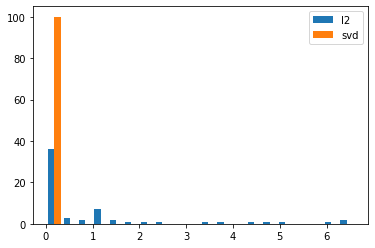

In [20]:
# Which is more noise resistant (l2 or svd)?
# SVD seems to do better
N_views = 20
noise_level = 0.1

l2_errors = []
svd_errors = []

for _ in tqdm(range(100)):
    point_3d, points_2d_h, points_2d, noisy_points_2d_h, noisy_points_2d, projection_mat, transform_mats = gen_problem(
    N_views, noise_level)
    solved_point = solve_problem(transform_mats, projection_mat, noisy_points_2d_h)
    res = minimize(error, solved_point, (noisy_points_2d, transform_mats, projection_mat))
    l2_optimum = res['x']
    if res['success']:
        l2_errors.append(np.linalg.norm(point_3d - l2_optimum))
    svd_errors.append(np.linalg.norm(point_3d - solved_point))

l2_errors = np.array(l2_errors)
svd_errors = np.array(svd_errors)

plt.hist([l2_errors, svd_errors], bins=20, label=['l2', 'svd'])
plt.legend()
plt.show()